In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from enum import Enum, IntEnum

import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch import nn
from torchsummary import summary
import torch
print (f'torch.__version__: {torch.__version__}')
import tensorflow as tf
import cv2 as cv
from torchvision import transforms

import enums
import viz
import configuration
import customdataset
import transformers
import models
import feature_helpers
from utilmethods import create_output_folders, check_torch_mps_device, make_torch_deterministic

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import loguniform
from tqdm.notebook import tqdm

check_torch_mps_device()
device = 'cpu'
device = 'mps'

config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)

LABELS_TO_INCLUDE = config.class_dict.keys()
# LABELS_TO_INCLUDE=[0,1,2,9]

# When num samples increases plotting PCA and TSNE can crash. So better to not run those cells during the main training.    
NUM_SAMPLES_TO_LOAD = 540
IMAGE_TYPES = [enums.ImageTypes.ORIGINAL,enums.ImageTypes.POSE, enums.ImageTypes.FACE]

torch.__version__: 1.13.0
tensor([1.], device='mps:0')


## Load Data

In [95]:
%%time
# Load the data
data = feature_extractor.load_data(image_types=IMAGE_TYPES, labels=LABELS_TO_INCLUDE, shuffle=True, sample_type=enums.SampleType.TRAIN_VALIDATION,
                                   count_per_label=NUM_SAMPLES_TO_LOAD, include_feature_vectors=False)
print(f'Loaded {data.shape[0]} samples.')


Loading 5400 samples:   0%|          | 0/5400 [00:00<?, ?samples/s]

load_data::df cols:Index(['filename', 'label', 'original', 'pose', 'face'], dtype='object')
Loaded 5400 samples.
CPU times: user 8min, sys: 1min 36s, total: 9min 37s
Wall time: 1min 46s


In [99]:
%%time
features_list = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data[enums.DataColumn.FILENAME.value], data[enums.DataColumn.LABEL.value])
# pixel_features = data[enums.DataColumn.PIXEL_VECTOR.value].to_numpy()
# hog_features = data[enums.DataColumn.HOG_VECTOR.value].to_numpy()
# cnn_features = data[enums.DataColumn.CNN_VECTOR.value].to_numpy()
# canny_features = data[enums.DataColumn.CANNY_VECTOR.value].to_numpy()
# pose_features = data[enums.DataColumn.POSE_VECTOR.value].to_numpy()
features_names = ['Pixel', 'Hog', 'CNN', 'Canny', 'Pose', 'Keypoints']
[pixel_features, hog_features, cnn_features, canny_features, pose_features, keypoints_features] = features_list
# Just keep cnn and keypoints_features as other features are too big.
features_list = [keypoints_features]
features_names = ['Keypoints']
y = data[enums.DataColumn.LABEL.value]

print(f'Loaded {data.shape[0]} samples with {data.columns} columns.')
print(f'hog_features:{hog_features.shape}, hog_features.min:{np.min(hog_features)}, hog_features.max:{np.max(hog_features)}')
print(f'pixel_features:{pixel_features.shape}, pixel_features.min:{np.min(pixel_features)}, pixel_features.max:{np.max(pixel_features)}')
print(f'cnn_features:{cnn_features.shape}, cnn_features.min:{np.min(cnn_features)}, cnn_features.max:{np.max(cnn_features)}')
print(f'canny_features:{canny_features.shape}, canny_features.min:{np.min(canny_features)}, canny_features.max:{np.max(canny_features)}')
print(f'pose_features:{pose_features.shape}, pose_features.min:{np.min(pose_features)}, pose_features.max:{np.max(pose_features)}')
print(f'keypoints_features:{keypoints_features.shape}, keypoints_features.min:{np.min(keypoints_features)}, keypoints_features.max:{np.max(keypoints_features)}')

print()


Loading feature vectors:   0%|          | 0/5400 [00:00<?, ?images/s]

Loaded 5400 samples with Index(['filename', 'label', 'original', 'pose', 'face'], dtype='object') columns.
hog_features:(5400, 5776), hog_features.min:0.0, hog_features.max:1.0
pixel_features:(5400, 25600), pixel_features.min:0.0, pixel_features.max:0.9999000430107117
cnn_features:(5400, 2048), cnn_features.min:0.0, cnn_features.max:1.607669472694397
canny_features:(5400, 25600), canny_features.min:0, canny_features.max:255
pose_features:(5400, 65536), pose_features.min:0.0, pose_features.max:0.6640035510063171
keypoints_features:(5400, 24), keypoints_features.min:-0.5003660321235657, keypoints_features.max:0.7140247821807861

CPU times: user 8.03 s, sys: 6.42 s, total: 14.4 s
Wall time: 23.9 s


## Dimensionality Reduction

In [118]:
# Helpers for vizualizing
def plot_PCA(X_list, names, n_components=2):
    pca_list, xpca_list = feature_extractor.get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'g-', 'r-', 'k-', 'y-']
    plot_labels = [f'{name} features' for name in names]
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=plot_labels[i])
    plt.xticks(np.arange(n_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(visible=True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=None, rect=None)
    plt.show()

def plot_classes(X, y, ax, title, included_labels):
    colormap = plt.cm.tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
    for k, label in enumerate(included_labels):
        if X.shape[1] == 2:
            ax.scatter(X[y==label, 0], X[y==label, 1], alpha=0.5, facecolors=colorst[k], label=config.class_dict[label])
        else:
            ax.scatter(X[y==label, 0], X[y==label, 1], X[y==label, 2], alpha=0.5, facecolors=colorst[k], label=config.class_dict[label])
    ax.set_title(title)
    
def plot_components(features_list, X_pcas, X_tsnes, names, included_labels=LABELS_TO_INCLUDE):
    # project the features into 2 dimensions
    fig, ax = plt.subplots(nrows=len(features_list), ncols=2, figsize=(10,5))
    if len(features_list) == 1:
        ax = [ax]

    # y is the class labels
    for i in range(len(features_list)):
        plot_classes(X_pcas[i], y, ax[i][0], title=f'{names[i]} PCA', included_labels=LABELS_TO_INCLUDE)
        plot_classes(X_tsnes[i], y, ax[i][1], title=f'{names[i]} tSNE', included_labels=LABELS_TO_INCLUDE)
    
    handles, plot_labels = ax[0][0].get_legend_handles_labels()
    fig.legend(handles, plot_labels, loc='upper center')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=12, rect=None)
    plt.show()

Doing PCA(24):   0%|          | 0/1 [00:00<?, ?images/s]

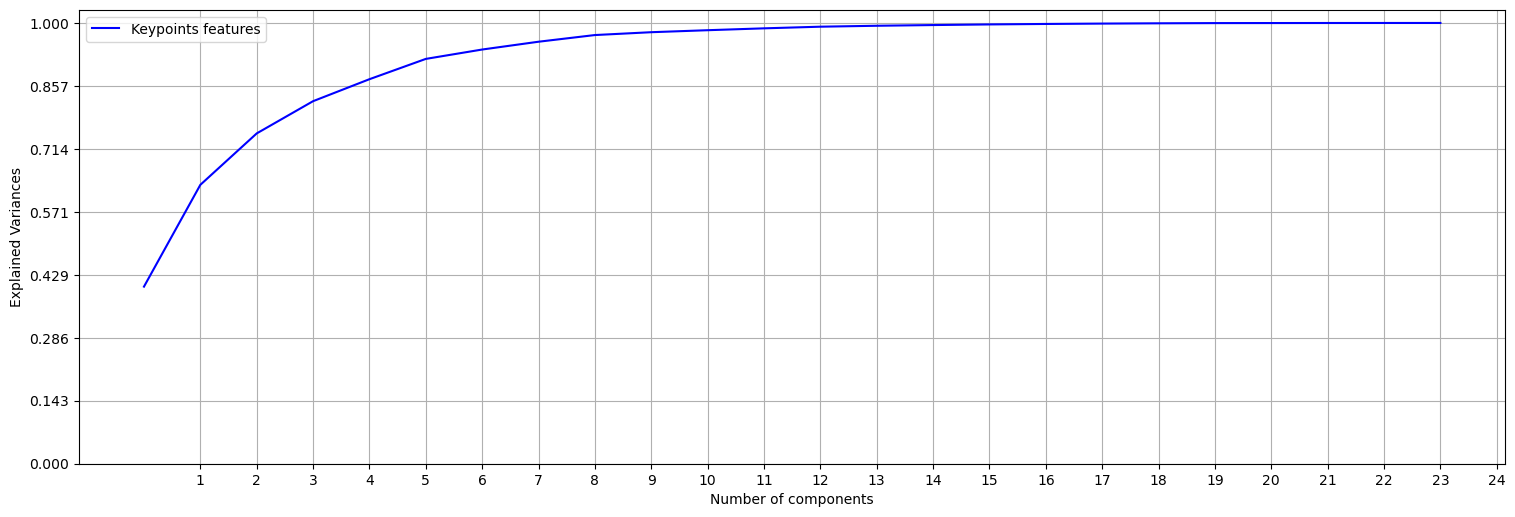

CPU times: user 1.29 s, sys: 51 ms, total: 1.34 s
Wall time: 349 ms


In [119]:
%%time
plot_PCA(features_list, features_names, n_components=24)

Doing PCA(2):   0%|          | 0/1 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/1 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


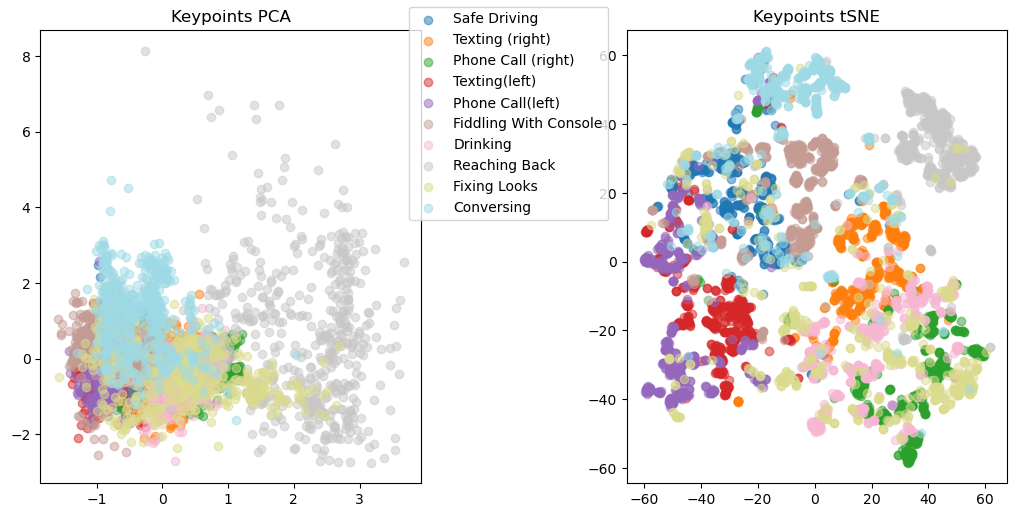

CPU times: user 2min 11s, sys: 2.48 s, total: 2min 13s
Wall time: 23.6 s


In [120]:
%%time
def visualize_components():
    pcas = feature_extractor.get_PCA(features_list, n_components=2)[-1]
    tsnes = feature_extractor.get_tsne(features_list, n_components=2)
    plot_components(features_list, 
                    pcas, 
                    tsnes,
                    features_names,
                    included_labels=LABELS_TO_INCLUDE)
visualize_components()

## KNN Classification

In [127]:
# Load feature vectors
# X_pixels_pca, X_hog_pca, X_CNN_pca, X_canny_pca, X_pose_pca = feature_extractor.get_PCA(features_list, n_components=2)[-1]
# X_pixels_tsne, X_hog_tsne, X_CNN_tsne, X_canny_tsne, X_pose_tsne = feature_extractor.get_tsne(features_list, n_components=2)
[X_keypoints_pca] = feature_extractor.get_PCA(features_list, n_components=2)[-1]
print(np.array(X_keypoints_pca).shape)
[X_keypoints_tsne] = feature_extractor.get_tsne(features_list, n_components=2)
print(np.array(X_keypoints_tsne).shape)

Doing PCA(2):   0%|          | 0/1 [00:00<?, ?images/s]

(5400, 2)


Doing tSNE(2):   0%|          | 0/1 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(5400, 2)


In [128]:
def calc_accuracy(knn, pca, y, idx):
    knn.fit(pca, y)
    accuracy = 0
    for i in idx:
        label = knn.predict([pca[i,:]])
        if label[0] == y[i]:
            accuracy +=1
    return accuracy

def accuracies(n_samples):
    knn = KNeighborsClassifier(n_neighbors = 3)
    idx = np.random.choice(np.arange(len(y)), n_samples, replace=False)
    # print(y[idx])
    print(f'Accuracies from {n_samples} samples:')
    # print('Pixel PCA Accuracy: ', calc_accuracy(knn, X_pixels_pca, y, idx)/n_samples)
    # print('Pixel tSNE Accuracy: ', calc_accuracy(knn, X_pixels_tsne, y, idx)/n_samples)
    # print('HOG PCA Accuracy: ', calc_accuracy(knn, X_hog_pca, y, idx)/n_samples)
    # print('HOG tSNE Accuracy: ', calc_accuracy(knn, X_hog_tsne, y, idx)/n_samples)
    # print('CNN PCA Accuracy: ', calc_accuracy(knn, X_CNN_pca, y, idx)/n_samples)
    # print('CNN tSNE Accuracy: ', calc_accuracy(knn, X_CNN_tsne, y, idx)/n_samples)
    # print('Canny PCA Accuracy: ', calc_accuracy(knn, X_canny_pca, y, idx)/n_samples)
    # print('Canny tSNE Accuracy: ', calc_accuracy(knn, X_canny_tsne, y, idx)/n_samples)
    # print('Pose PCA Accuracy: ', calc_accuracy(knn, X_pose_pca, y, idx)/n_samples)
    # print('Pose tSNE Accuracy: ', calc_accuracy(knn, X_pose_tsne, y, idx)/n_samples)
    print('Keypoints PCA Accuracy: ', calc_accuracy(knn, X_keypoints_pca, y, idx)/n_samples)
    print('Keypoints tSNE Accuracy: ', calc_accuracy(knn, X_keypoints_tsne, y, idx)/n_samples)

accuracies(100)

Accuracies from 100 samples:
Keypoints PCA Accuracy:  0.68
Keypoints tSNE Accuracy:  0.94


## Logistic Regression

In [129]:
# get the train and test split
# [pixel_features, hog_features, cnn_features, canny_features, pose_features] = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=config.SEED)

In [130]:
def train_classifier(in_feat, in_y, in_train_idx, val_idx):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # classifier with cross validation
    
    1e-5, 1e-4, 1e-3, ..., 1, 10, 100,
    param_grid = {"C": loguniform(1e-3, 1e5)}
    # clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=config.SEED), param_grid, n_iter=100)
    clf = RandomizedSearchCV(LogisticRegression(penalty='l1', max_iter=5000, solver='saga', random_state=config.SEED), param_grid, n_iter=10)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    return accuracy_score(y_val, y_pred)

In [ ]:
def train_and_check(features, n_components, name, y, train_idx, val_idx):
    pbar = tqdm(desc=name, total=len(n_components) + 1, position=0, leave=True)
    acc = []
    for n in n_components:
        pbar.set_description(f'{name}: Computing PCA({n})')
        _, X = feature_extractor.get_PCA([features], n_components=n+1)
        acc.append(train_classifier(X[0], y, train_idx, val_idx))
        pbar.update(1)
    pbar.set_description(f'{name}: Training classifier')
    acc.append(train_classifier(features, y, train_idx, val_idx))
    pbar.update(1)
    pbar.close()
    return acc

# get accuracy with different features
n_components = [50, 100, 150, 200]
n_components = [200]
# print('Pixel Feature Accuracy')
# pixel_acc = train_and_check(pixel_features, n_components, 'Pixel', y, train_idx, val_idx)
# print('Pose Feature Accuracy')
# pose_acc = train_and_check(pose_features, n_components, 'Pose', y, train_idx, val_idx)
print('Keypoints Feature Accuracy')
keypoints_acc = train_and_check(keypoints_features, [3, 6, 9, 12, 15, 18, 21, 23], 'Keypoints', y, train_idx, val_idx)
# print('CNN Feature Accuracy')
# CNN_acc = train_and_check(CNN_features, n_components, 'CNN', y, train_idx, val_idx)

# pixel_tqdm = tqdm(prefix='Pixel', total=len(n_components) + 1, position=0, leave=True)
# pixel_acc = []
# for n in n_components:
#     pixel_tqdm.set_description(f'Computing PCA({n})')
#     _, X = feature_extractor.get_PCA([pixel_features], n_components=n+1)
#     pixel_acc.append(train_classifier(X[0], y, train_idx, val_idx))
#     pixel_tqdm.update(1)
# pixel_tqdm.set_description(f'Training calssifier')
# pixel_acc.append(train_classifier(pixel_features, y, train_idx, val_idx))
# pixel_tqdm.update(1)
# pixel_tqdm.close()

# print('Pose Feature Accuracy')
# pose_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([pose_features], n_components=n+1)
#   pose_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# pose_acc.append(train_classifier(pose_features, y, train_idx, val_idx))

# print('CNN Feature Accuracy')
# CNN_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([CNN_features], n_components=n+1)
#   CNN_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# CNN_acc.append(train_classifier(CNN_features, y, train_idx, val_idx))

Keypoints Feature Accuracy


Keypoints:   0%|          | 0/9 [00:00<?, ?it/s]

Doing PCA(4):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(7):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(10):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(13):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(16):   0%|          | 0/1 [00:00<?, ?images/s]

In [79]:
print(keypoints_acc)

[0.605, 0.7183333333333334, 0.7816666666666666, 0.79, 0.81, 0.8083333333333333, 0.8116666666666666, 0.8283333333333334, 0.8233333333333334]


In [81]:
print(n_components)

[200]


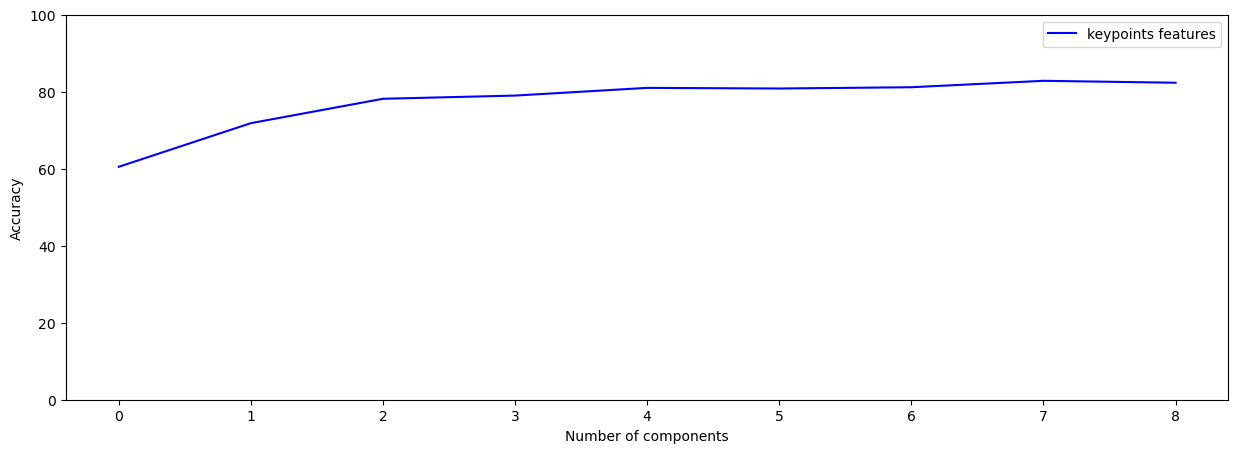

In [86]:
# plot the accuracy graph
plt.figure(figsize=(15,5))
# plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
# plt.plot(np.array(pose_acc)*100, 'g-', label='pose features')
# plt.plot(np.array(CNN_acc)*100, 'k-', label='CNN features')

plt.plot(np.array(keypoints_acc)*100, 'b-', label='keypoints features')

# xtick_labels = [f'{i+1}' for i in n_components] + ['All']
# plt.xticks(np.arange(2), labels=xtick_labels)
# plt.yticks(np.linspace(0, 100, 8))
# plt.grid(b=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend()
plt.show()